# Test FFT for CW model and likelihood

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

from miscMCMC.samplers.mh_mcmc import MH_MCMC

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# make PTA and likelihood objects
pta = PTA(Np=15,
          Tspan_yr=15.,
          Nf=5,
          Nf_cw=15,
          window_ext_yr=3.,
          model_wn=False,
          model_rn=False,
          model_gwb=False,
          model_cw=True,
          gwb_free_spectral=False,
          seed=111)
l = get_likelihood_obj(pta)

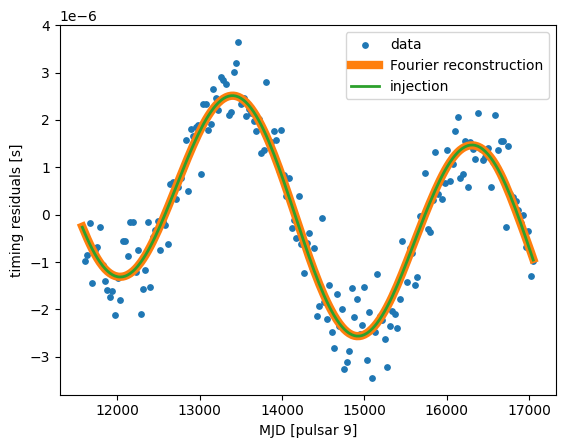

In [3]:
psr_ndx = 8
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx],
            color='C0', label='data', s=15)
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.Fs_cw[psr_ndx] @ \
         pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx],
         color='C1', label='Fourier reconstruction', lw=6)
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.cw_delay_toa_input(pta.x_inj[pta.cw_psr_ndxs], pta.toas)[psr_ndx],
         color='C2', label='injection', lw=2)
plt.legend()
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('timing residuals [s]')
plt.show()

In [4]:
@jit
def lnpost(x):

    # prior
    ln_prior_val = l.uniform_lnprior(x)
    ln_prior_val += l.psr_dist_lnprior(x[pta.psr_dist_ndxs])

    # likelihood
    a_cw = pta.get_CW_coefficients(x[pta.cw_psr_ndxs]).flatten()
    ln_like_val = l.lnlike_cwbasis(pta.efacs_inj, jnp.zeros(pta.Na_PTA), a_cw)
    # ln_like_val = l.lnlike(pta.efacs_inj, a_cw)

    return ln_prior_val + ln_like_val

vectorized_lnpost = jit(vmap(lnpost))

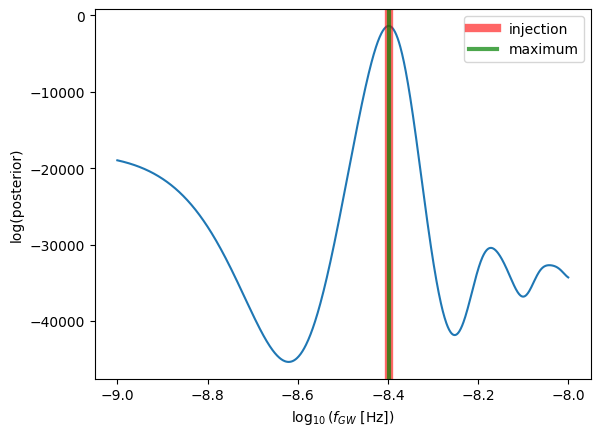

In [5]:
# plot cross-section of posterior
param_ndx = 1
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [6]:
samples, lnposts = MH_MCMC(num_samples=int(1e5),
                           ln_pdf_func=lnpost,
                           x0=pta.x_inj,
                           x_mins=pta.x_mins,
                           x_maxs=pta.x_maxs)

jump proposal acceptance rates 

Fisher_proposal: 0.7305194805194806
DE_proposal: 0.46542123226154125


In [7]:
# store samples in object for post-processing
samples = Samples(samples_arr=samples,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

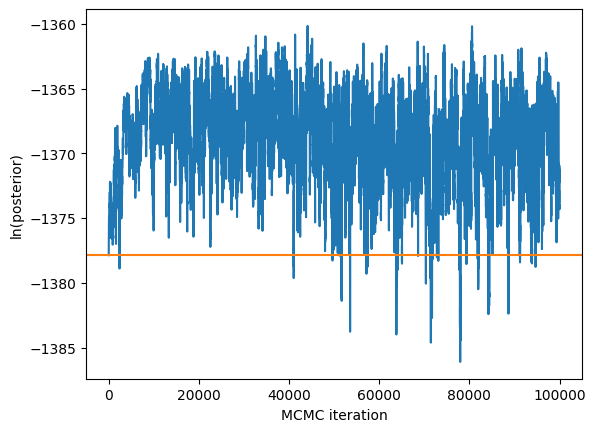

In [8]:
samples.plt_posterior_vals()

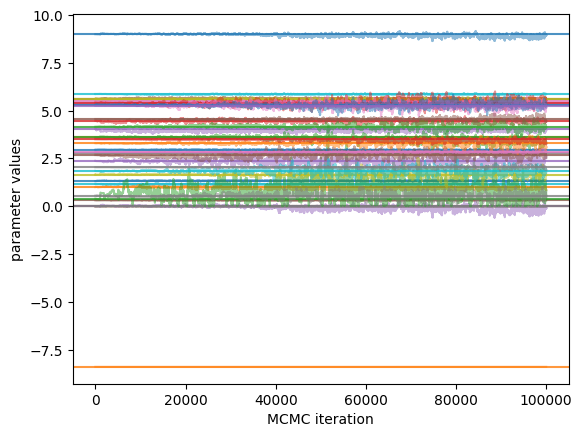

In [9]:
samples.trace_plt()

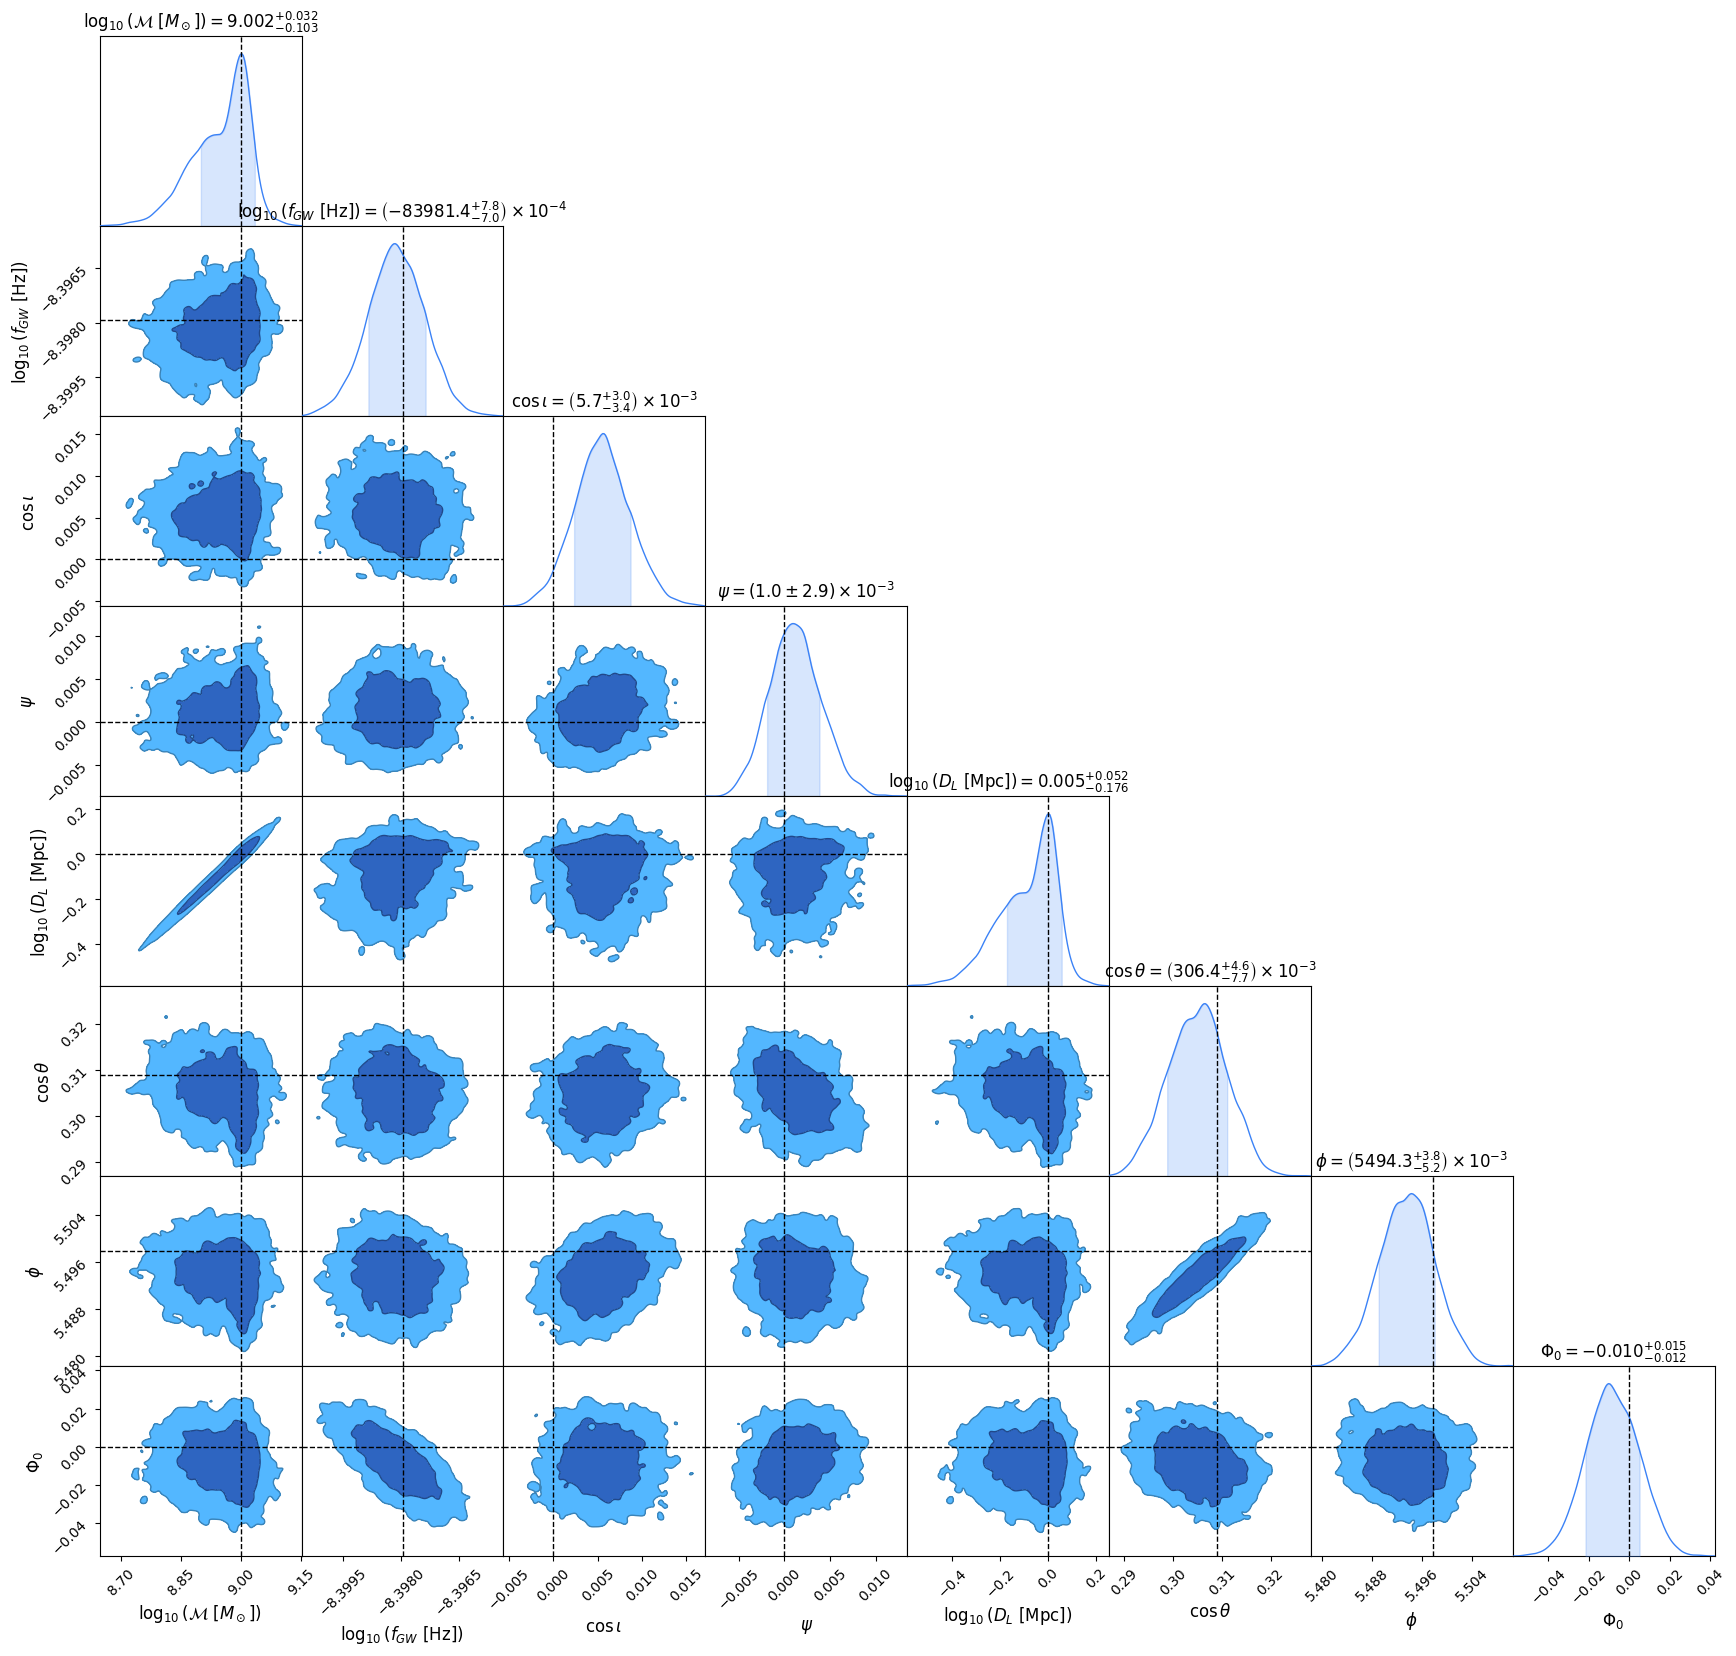

In [10]:
samples.corner_plt(pta.cw_ndxs, burnin=int(1e4))

In [2]:
# check if CW reconstruction is accurate
Nf_cws = np.arange(2, 20)
window_ext_yrs = np.linspace(0, 10, 11, endpoint=True)
# Nf_cws = np.arange(2, 25)
# window_ext_yrs = np.linspace(0, 10, 11, endpoint=True)
num_draws = 10_000

avg_powers = np.zeros((Nf_cws.shape[0], window_ext_yrs.shape[0]))
for i, Nf_cw in enumerate(Nf_cws):
    print(f'Nf_cw = {Nf_cw}', end='\r')
    for j, window_ext_yr in enumerate(window_ext_yrs):
        # print(f'window_ext = {window_ext_yr}', end='\r')
        # make PTA object
        pta = PTA(Np=20,
                Tspan_yr=15.,
                Nf=5,
                Nf_cw=Nf_cw,
                window_ext_yr=window_ext_yr,
                model_wn=False,
                model_rn=False,
                model_gwb=False,
                model_cw=True,
                gwb_free_spectral=False,
                seed=1)
        
        def get_cw_approx(x_cw_psr):    
            a_cw = pta.get_CW_coefficients(x_cw_psr)
            cw_residuals = jnp.matmul(pta.Fs_cw, a_cw[..., None]).squeeze(-1)  
            cw_residuals = jnp.matmul(pta.Rs, cw_residuals[..., None]).squeeze(-1)  
            return cw_residuals
        
        def get_cw_true(x_cw_psr):
            cw_residuals = pta.cw_delay_toa_input(x_cw_psr, pta.toas)
            cw_residuals = jnp.matmul(pta.Rs, cw_residuals[..., None]).squeeze(-1)
            return cw_residuals
        
        # vectorize function to get cw signals
        vec_cw_true = jit(vmap(get_cw_true, in_axes=(0)))
        vec_cw_approx = jit(vmap(get_cw_approx, in_axes=(0)))

        # draw from prior and get CW signals and reconstruction
        x_cw_psr = jr.uniform(jr.key(i), (num_draws, pta.N_cw_psr),
                            minval=pta.x_mins[pta.cw_psr_ndxs],
                            maxval=pta.x_maxs[pta.cw_psr_ndxs])
        
        # get difference between two methods
        true_cw = vec_cw_true(x_cw_psr)
        approx_cw = vec_cw_approx(x_cw_psr)
        residuals = true_cw - approx_cw
        if np.any(np.isnan(residuals)):
            print('CW method has NaNs!')
        # get power in residuals
        res_power = jnp.sum(residuals**2., axis=2) / jnp.sum(true_cw**2., axis=2)
        # if np.any(res_power > 1.):
        #     ndx = np.argwhere(res_power > 1.)[0]
        #     plt.plot(true_cw[ndx[0], ndx[1]], lw=4, label='true')
        #     plt.plot(approx_cw[ndx[0], ndx[1]], label='approx')
        #     plt.legend()
        #     plt.show()
        avg_powers[i, j] = jnp.mean(res_power)
    

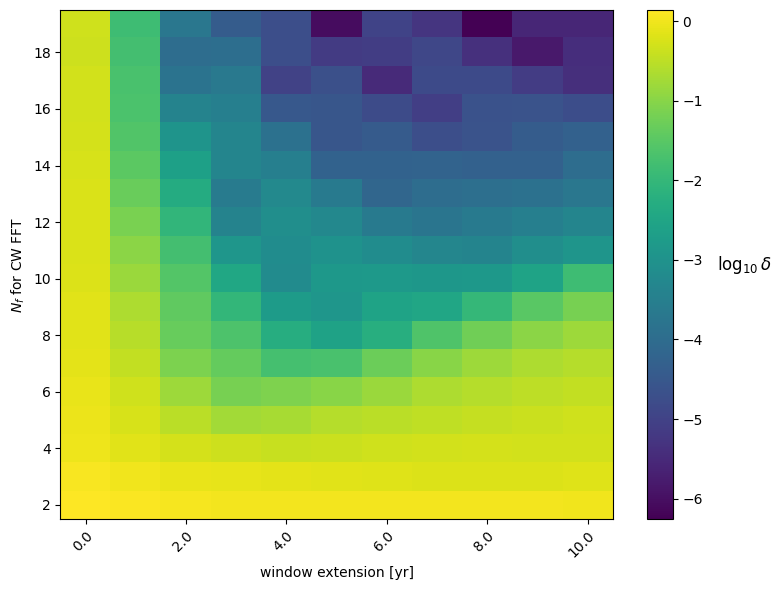

In [3]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
cax = ax.imshow(np.log10(avg_powers), aspect='auto', cmap='viridis', origin='lower')

# Add colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
# cbar.set_label(r'$\frac{|\delta \vec{t}_{{{CW}}} - \mathbf{F}\vec{a}_{{{CW}}}|^2}{|\delta \vec{t}_{{{CW}}}|^2}$',
#                loc='center', fontsize=14, labelpad=10)
cbar.set_label(r'$\log_{{{10}}}\delta$',
               loc='center', fontsize=12, labelpad=10)
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.yaxis.label.set_ha('left')
cbar.ax.yaxis.label.set_va('center')  

# Set title and axis labels
# ax.set_title('Relative error of CW Fourier representaion')
ax.set_xlabel(r'window extension [yr]')
ax.set_ylabel(r'$N_f$ for CW FFT')

# axes ticks
ax.set_xticks(np.arange(avg_powers.shape[1])[::2])
ax.set_yticks(np.arange(avg_powers.shape[0])[::2])
ax.set_xticklabels(window_ext_yrs[::2])
ax.set_yticklabels(Nf_cws[::2])

# Optionally rotate x-tick labels if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [8]:
# find lowest error for Nf = 15
min_ndx = np.argmin(avg_powers[np.where(Nf_cws == 15)])
min_window_ext = window_ext_yrs[min_ndx]
print(min_window_ext)

7.0


In [139]:
Nf_cw = 15
window_ext_yr = min_window_ext
num_draws = 1000

pta = PTA(Np=20,
        Tspan_yr=15.,
        Nf=5,
        Nf_cw=Nf_cw,
        window_ext_yr=window_ext_yr,
        model_wn=False,
        model_rn=False,
        model_gwb=False,
        model_cw=True,
        gwb_free_spectral=False,
        seed=1)

@jit
def get_cw_approx(x_cw_psr):    
    a_cw = pta.get_CW_coefficients(x_cw_psr)
    cw_residuals = jnp.matmul(pta.Fs_cw, a_cw[..., None]).squeeze(-1)  
    cw_residuals = jnp.matmul(pta.Rs, cw_residuals[..., None]).squeeze(-1)  
    return cw_residuals

@jit
def get_cw_true(x_cw_psr):
    cw_residuals = pta.cw_delay_toa_input(x_cw_psr, pta.toas)
    cw_residuals = jnp.matmul(pta.Rs, cw_residuals[..., None]).squeeze(-1)
    return cw_residuals

# vectorize function to get cw signals
vec_cw_true = jit(vmap(get_cw_true, in_axes=(0)))
vec_cw_approx = jit(vmap(get_cw_approx, in_axes=(0)))

# draw from prior and get CW signals and reconstruction
x_cw_psr = jr.uniform(jr.key(i), (num_draws, pta.N_cw_psr),
                    minval=pta.x_mins[pta.cw_psr_ndxs],
                    maxval=pta.x_maxs[pta.cw_psr_ndxs])

# get difference between two methods
true_cw = vec_cw_true(x_cw_psr)
approx_cw = vec_cw_approx(x_cw_psr)
residuals = true_cw - approx_cw
if np.any(np.isnan(residuals)):
    print('CW method has NaNs!')
# get power in residuals
res_power = jnp.sum(residuals**2., axis=2) / jnp.sum(true_cw**2., axis=2)
avg_power = jnp.mean(res_power)

In [140]:
print(avg_power)
print(np.max(res_power))

2.0484191356922155e-05
0.0017923364253541287


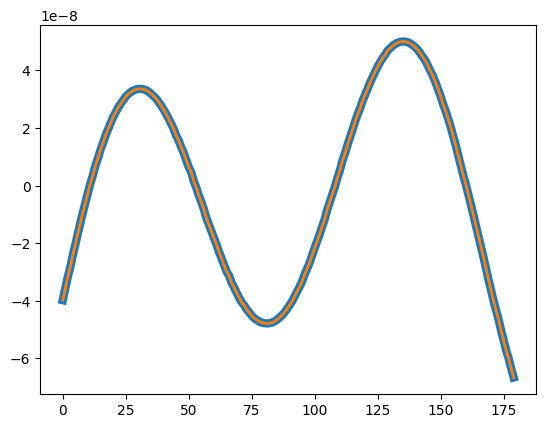

In [138]:
# check by plotting both models
ndx = np.random.choice(int(1e3))
psr_ndx = np.random.choice(20)
true_cw = pta.Rs[psr_ndx] @ get_cw_true(x_cw_psr[ndx])[psr_ndx]
approx_cw = pta.Rs[psr_ndx] @ get_cw_approx(x_cw_psr[ndx])[psr_ndx]
plt.plot(true_cw, lw=6)
plt.plot(approx_cw, lw=2)
plt.show()

In [134]:
%timeit get_cw_true(x_cw_psr[0])

143 μs ± 1.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [135]:
%timeit get_cw_approx(x_cw_psr[0])

67.3 μs ± 888 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [136]:
%timeit vec_cw_true(x_cw_psr)

30.3 ms ± 523 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
%timeit vec_cw_approx(x_cw_psr)

17.3 ms ± 8.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


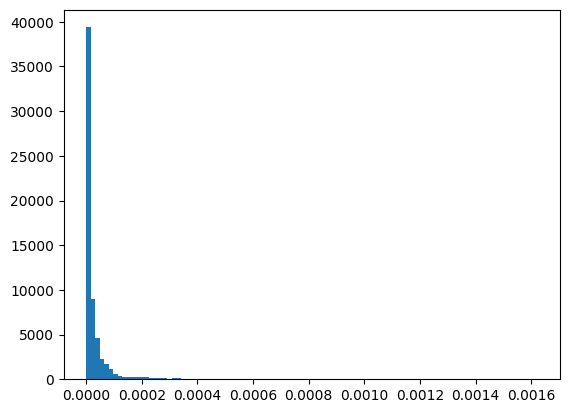

In [69]:
plt.hist(res_power.flatten(), bins=100, density=True)
plt.show()